 # Discussion 11A, Fall 2021

In [1]:
import numpy as np
from math import cos, sin, pi, sqrt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans, whiten

from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

%matplotlib widget

# seed the pseudo random number generator with 0 
# so that the results are consistent in all discussion sections
np.random.seed(0)

import IPython
from ipywidgets import interactive, widgets
from IPython.display import display, HTML

# Question 2 : PCA on artificial data

In this example we'll generate four clusters of data points on a plane, combine them into a single dataset, randomly embed it in a higher dimensional space, add quite a lot of noise, and then try to use PCA to separate the data into the original clusters.

## Generating 2D data

For each cluster we'll draw random points drawn from a Gaussian distribution centered around its mean, with a predefined standard deviation.

[You will learn more about probability, the gaussian distribution, mean and standard deviation in CS70. For now it is enough to know that the points of each clustered are centered around the mean and at least 95% are within twice the standard deviation from the mean.]

In [2]:
def cluster(mean, stddev, size):
    return np.random.multivariate_normal(mean, np.eye(mean.shape[0])*stddev**2, size).T

We'll create four clusters of 500 points each, centered around (5,5), (-5, -5), (-5, 5) and (5,-5) with standard deviation of 1.

In [3]:
N = 500

mean1 = np.array([5, 5])
mean2 = np.array([-5, -5])
mean3 = np.array([-5, 5])
mean4 = np.array([5,-5])
stddev = 1

cluster1 = cluster(mean1, stddev, N)
cluster2 = cluster(mean2, stddev, N)
cluster3 = cluster(mean3, stddev, N)
cluster4 = cluster(mean4, stddev, N)

We'll combine all clusters into a single dataset and shuffle it for good measure

In [4]:
dataset_2d = np.c_[cluster1, cluster2, cluster3, cluster4]
np.random.shuffle(dataset_2d)

The dataset looks pretty much like we expected.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
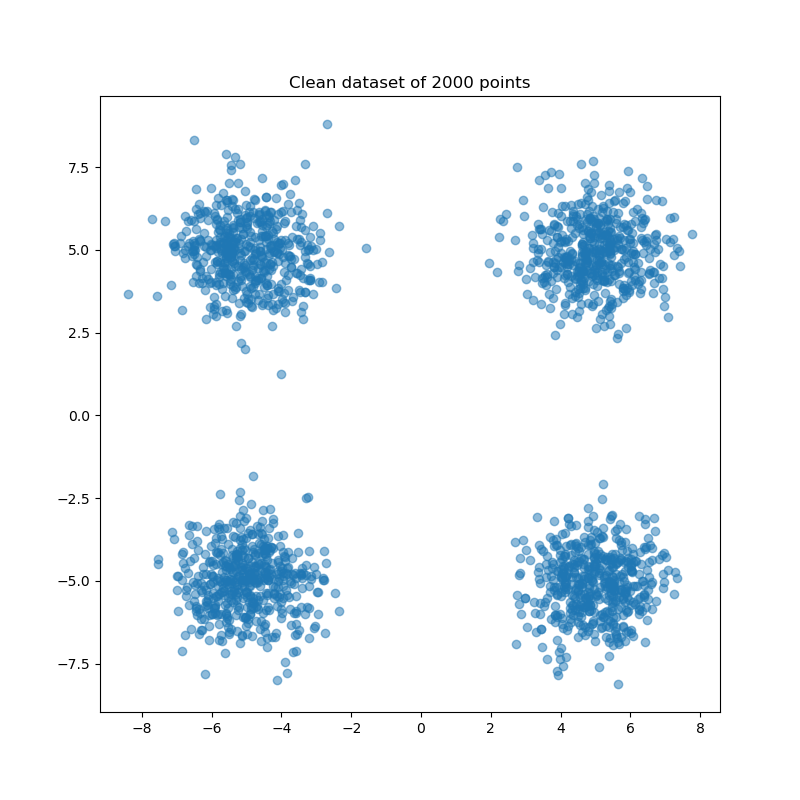

In [11]:
fig = plt.figure(figsize=(8,8))
plt.scatter(*dataset_2d, alpha=0.5)
plt.title('Clean dataset of 2000 points')
plt.show()

## Embedding the 2D data into a 25D space

We have a 2D dataset, we'll embed it into a 25 dimensional space by multiplying it with a random 25x2 matrix. To understand how this works, we'll first embed it in a three dimensional space in two ways.

In [12]:
xmin  = -1.0
xmax = 3.0
ymin = -1.0
ymax = 3.0

def embed_and_plot(M):
    dataset_3d = M @ dataset_2d
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    pplot = ax.scatter3D(*dataset_3d, alpha=0.15)


First, embed the our points in the X-Y plane:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
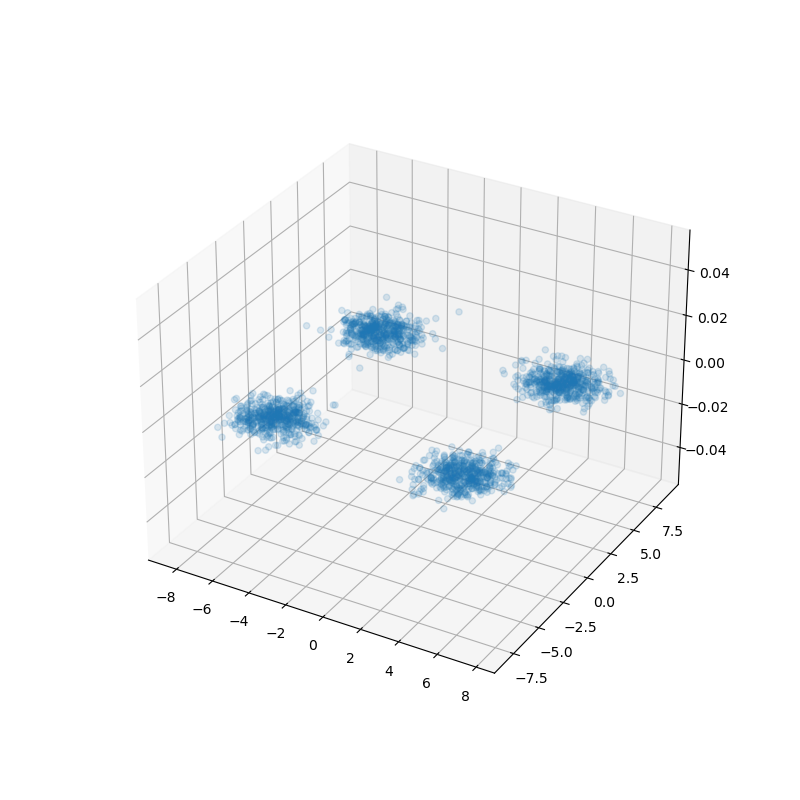

In [13]:
embed_and_plot(np.array([[1, 0],[0, 1], [0, 0]]))

Next, embed it as a different plane. From our point of view, it is now harder to separate the clusters.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
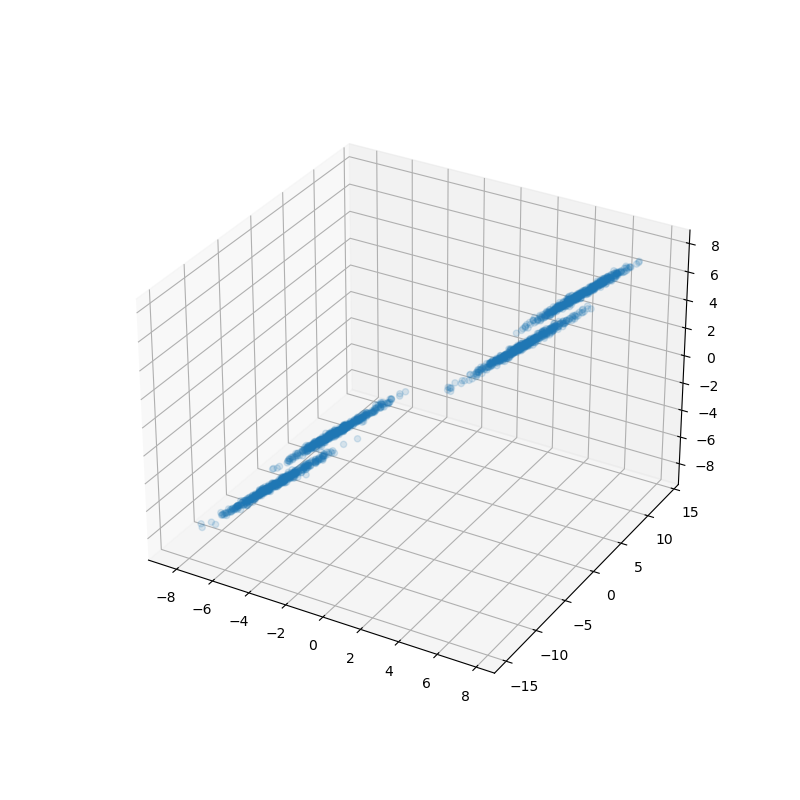

In [14]:
A = [[1, 0],
     [1, -1],
     [1, 0]]
embed_and_plot(
    np.array(A))

Now return to our 25-dimensional space. We'll generate a random 25x2 matrix and multiply the matrix by each point.

[Note that this matrix has to be of rank 2, otherwise the data will become one dimensional - but the probability of a random 25x2 matrix to be of rank less than 2 is negligible]

In [15]:
n = 25
M = np.random.rand(n, 2)
print("The rank of M is", np.linalg.matrix_rank(M))
dataset_nd = M @ dataset_2d 

The rank of M is 2


How does this data look like? Let's pick two random axes and view the data projected over these axis.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
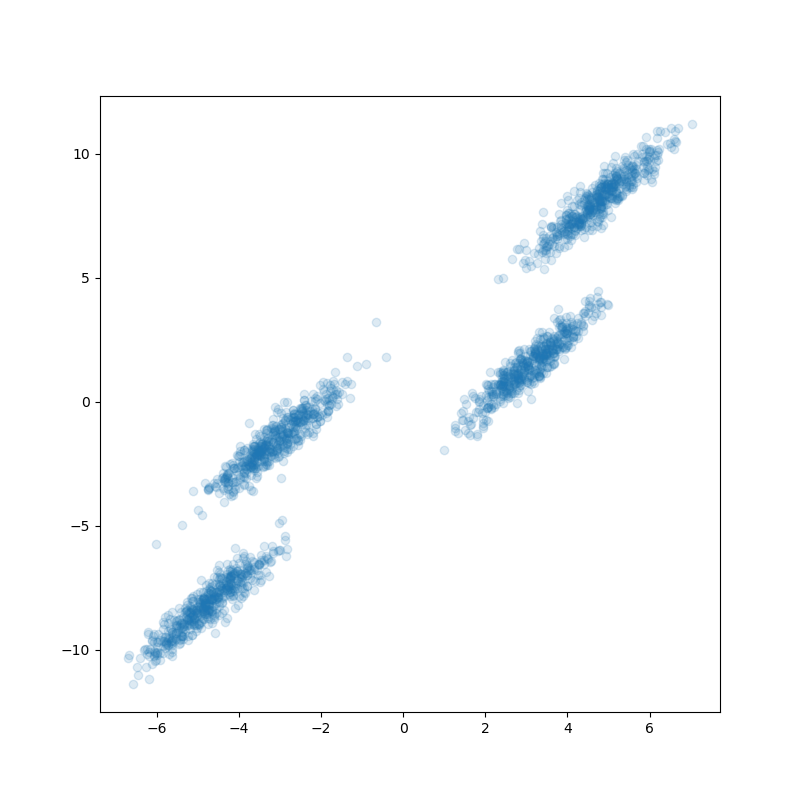

In [16]:
axes = np.random.randint(0, n, 2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(dataset_nd[axes[0]], dataset_nd[axes[1]], alpha=0.15)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
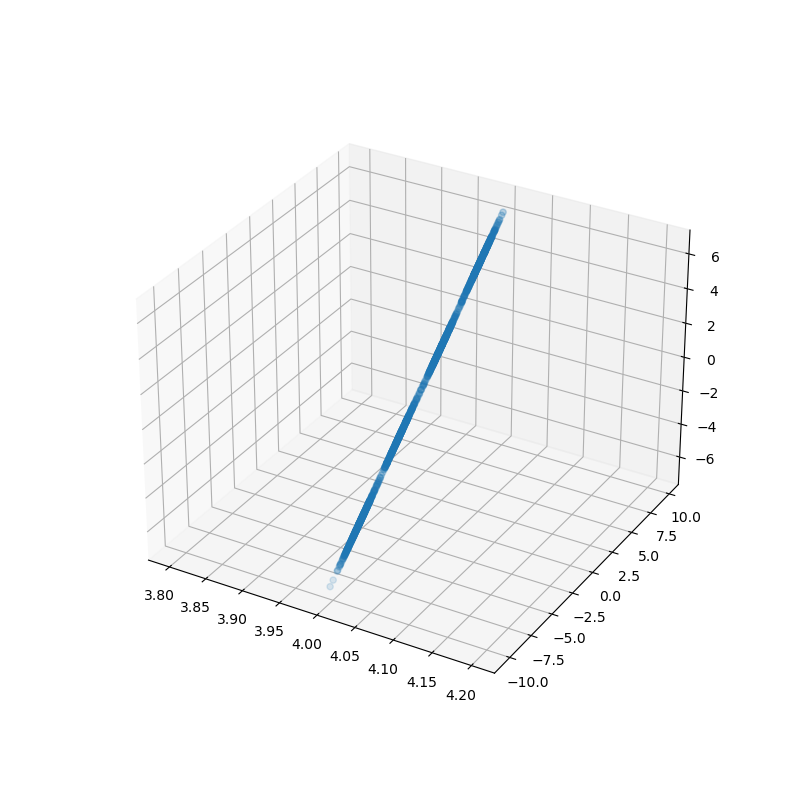

In [17]:
axes = np.random.randint(0, n, 3)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([axes[0]], dataset_nd[axes[1]], dataset_nd[axes[2]], alpha=0.15)

Not too bad, even though we picked random axes, the clusters are clearly distinguishable.

## Adding some noise
But what happens if we add random noise? let's add quite a lot of noise:

In [18]:
noise_stddev = 5
noise = np.random.multivariate_normal(np.zeros(n), np.eye(n)*noise_stddev**2, dataset_nd.shape[1]).T

noisy_dataset = dataset_nd + noise

Let's draw it again over the same axes:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
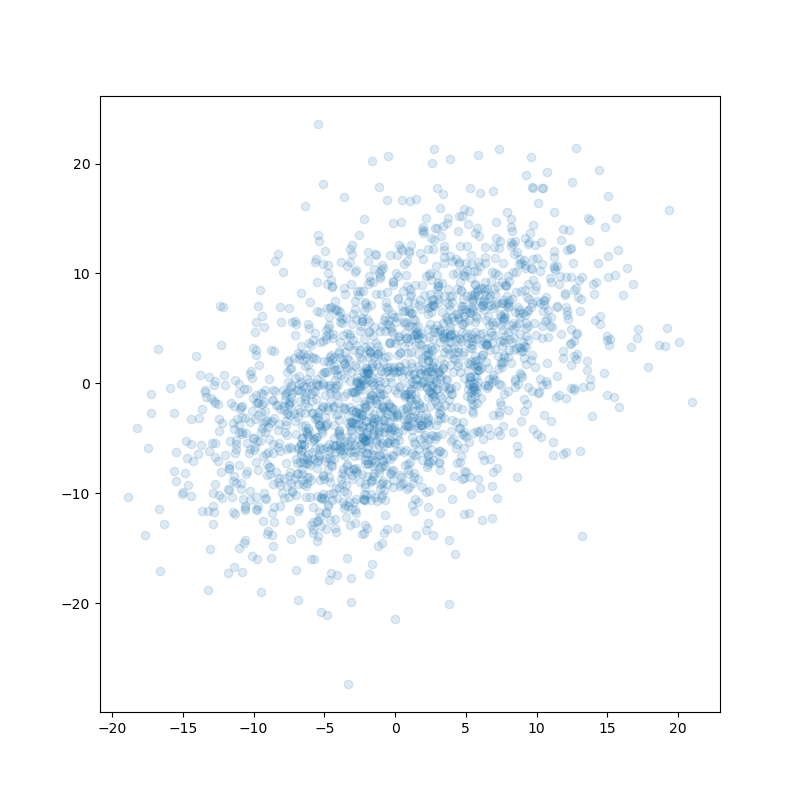

In [19]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(noisy_dataset[axes[0]], noisy_dataset[axes[1]], alpha=0.15)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
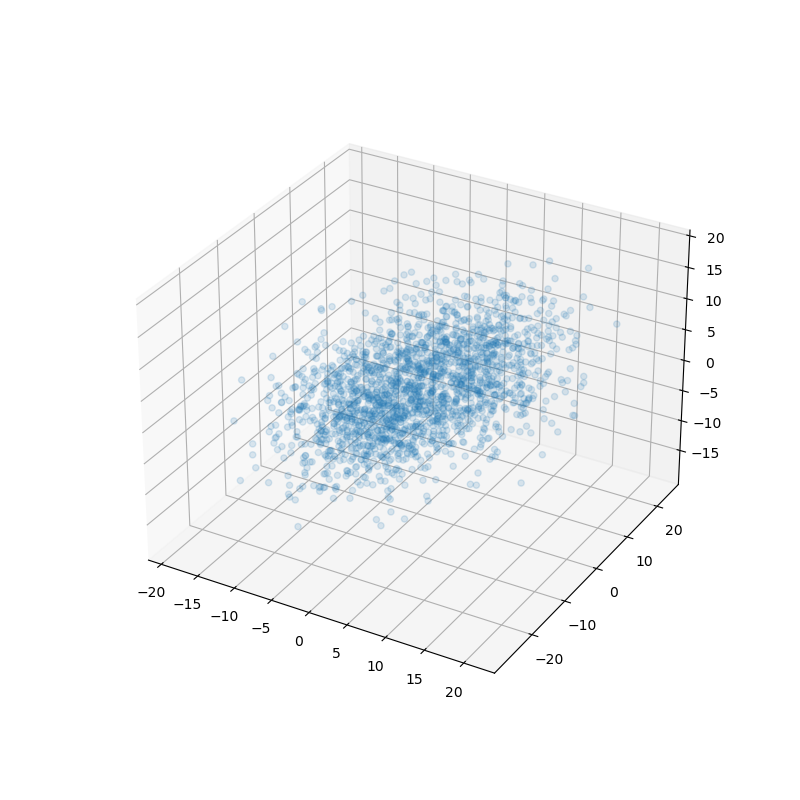

In [20]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(noisy_dataset[axes[0]], noisy_dataset[axes[1]], noisy_dataset[axes[2]], alpha=0.15)
plt.show()

The separate clusters are pretty much gone now, as the clusters are overshadowed by the noise.

## PCA
Can we use PCA to recover the clusters from the noise?
In PCA, we perform SVD and project over the columns of U that correspond to the singular values with the highest magnitude. These vectors are called the **principal components**.

In [21]:
U, S, V = np.linalg.svd(noisy_dataset)

In this case, we'll pick the first two principal components. Why two? we started with two dimensional data, so it makes sense to pick two principal components. We'll revisit this decision later.

In [22]:
PC = U[::,:2]
# We'll project the data into the first two principal components:
projected_cleandataset = PC.T.dot(dataset_nd)
projected_noisydataset = PC.T.dot(noisy_dataset)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
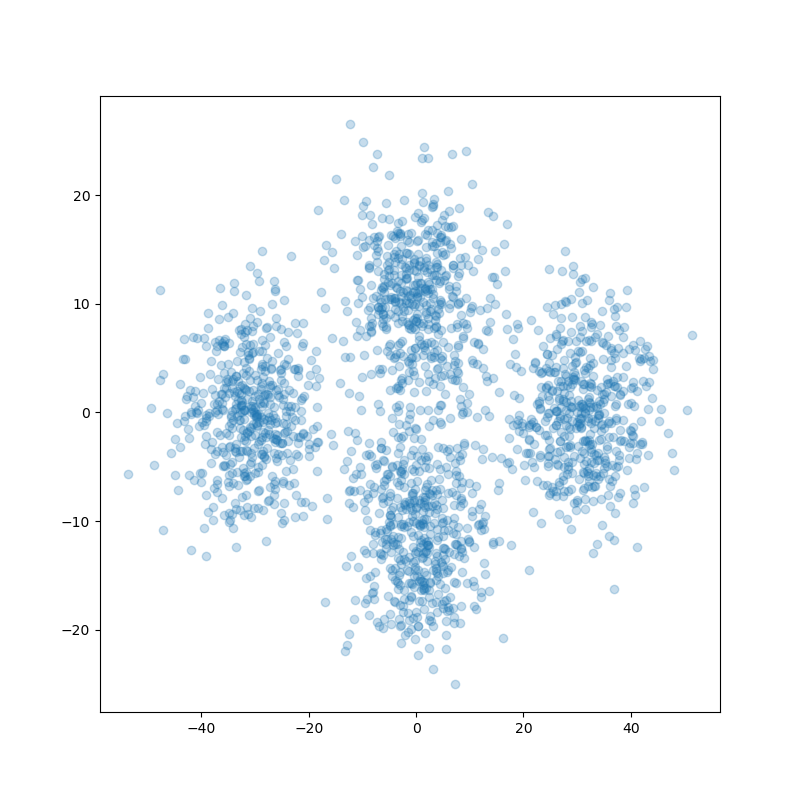

In [23]:
# Then plot the result:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(*projected_noisydataset, alpha=0.25)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
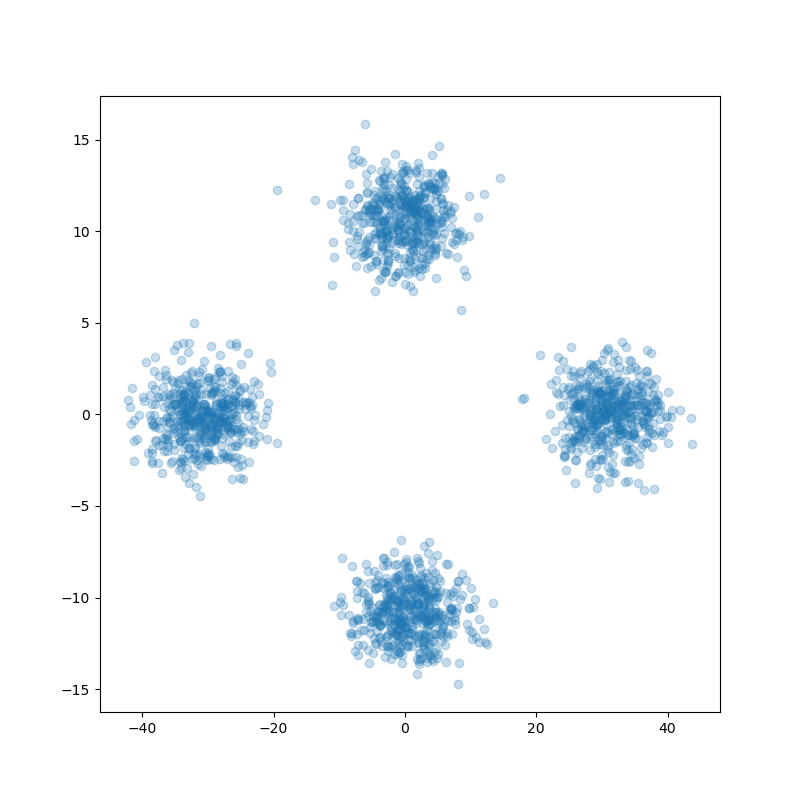

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(*projected_cleandataset, alpha=0.25)
plt.show()

In [25]:
PC = U[::,:3]
# We'll project the data into the first two principal components:
projected_cleandataset = PC.T.dot(dataset_nd)
projected_noisydataset = PC.T.dot(noisy_dataset)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
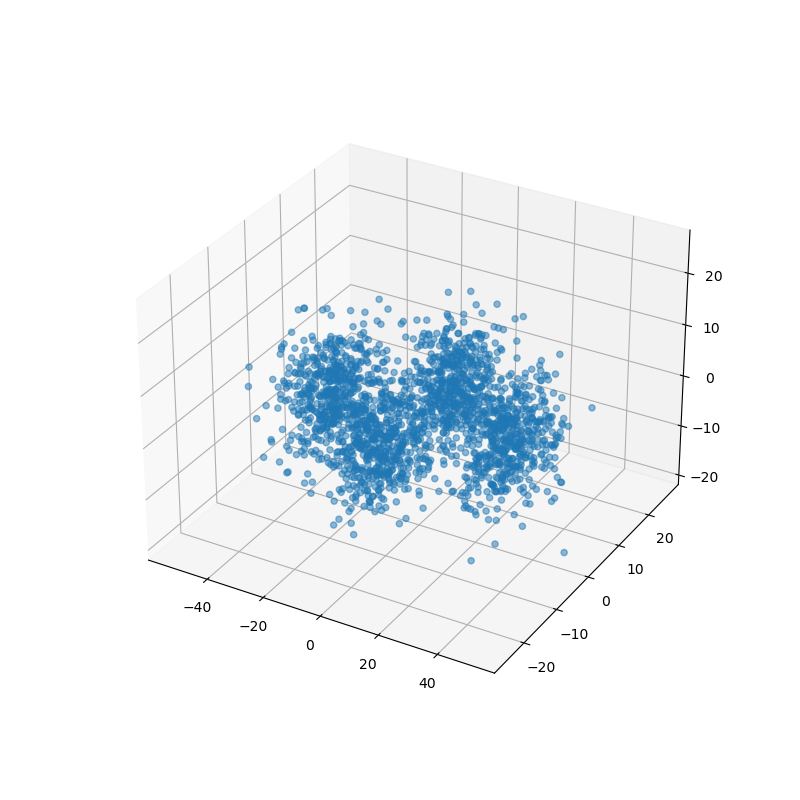

In [26]:
# Then plot the result:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*projected_noisydataset, alpha=0.5)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
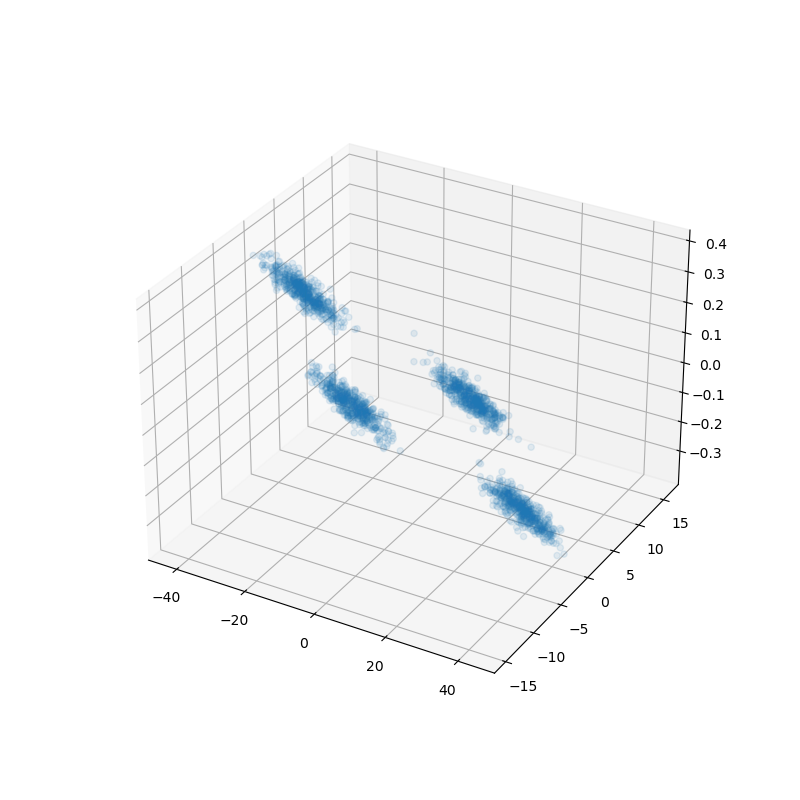

In [27]:
# Then plot the result:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*projected_cleandataset, alpha=0.1)
plt.show()

Even though we added a lot of noise, we still get distinguishable clusters, but they are blurring together on the boundaries. That's from the noise.

In [28]:
NextPC = U[::,2:4]
nextnoisyprojections = NextPC.T.dot(noisy_dataset)
nextcleanprojections = NextPC.T.dot(dataset_nd)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
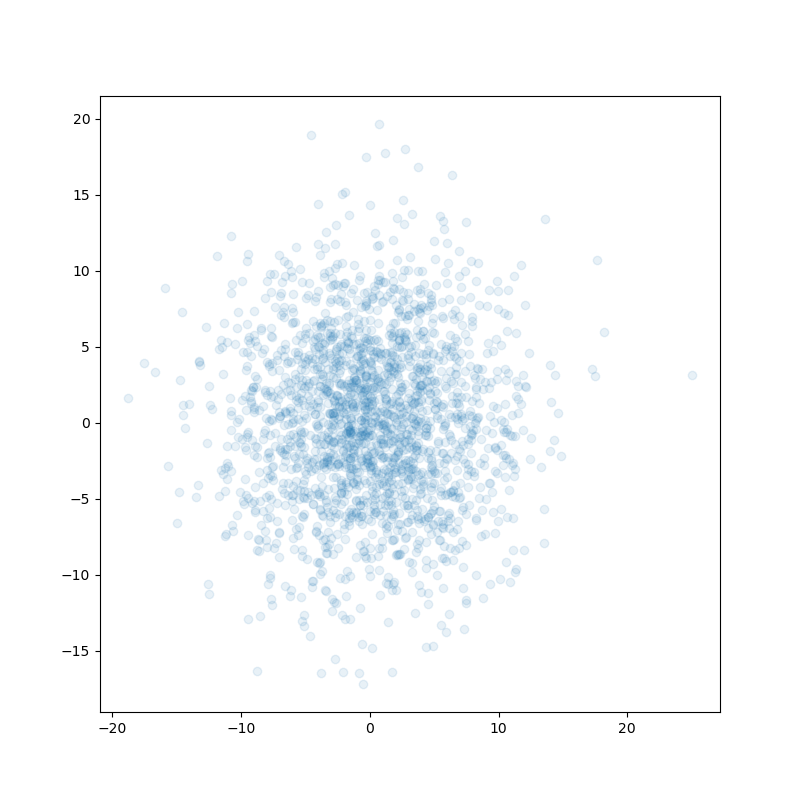

In [29]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(*nextnoisyprojections, alpha=0.1)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
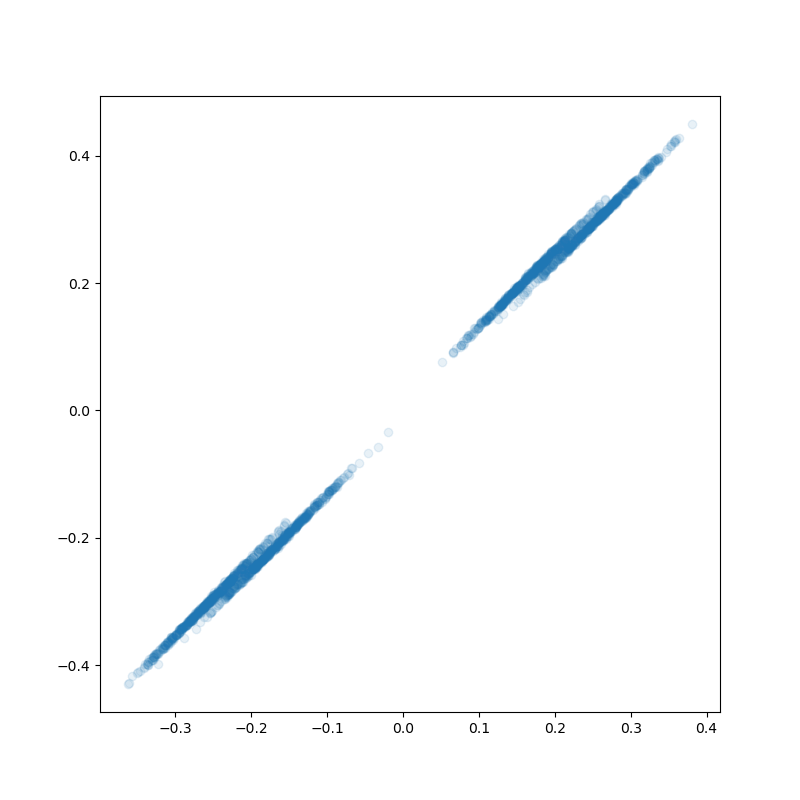

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(*nextcleanprojections, alpha=0.1)
plt.show()

In [31]:
NextPC = U[::,2:5]
nextnoisyprojections = NextPC.T.dot(noisy_dataset)
nextcleanprojections = NextPC.T.dot(dataset_nd)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
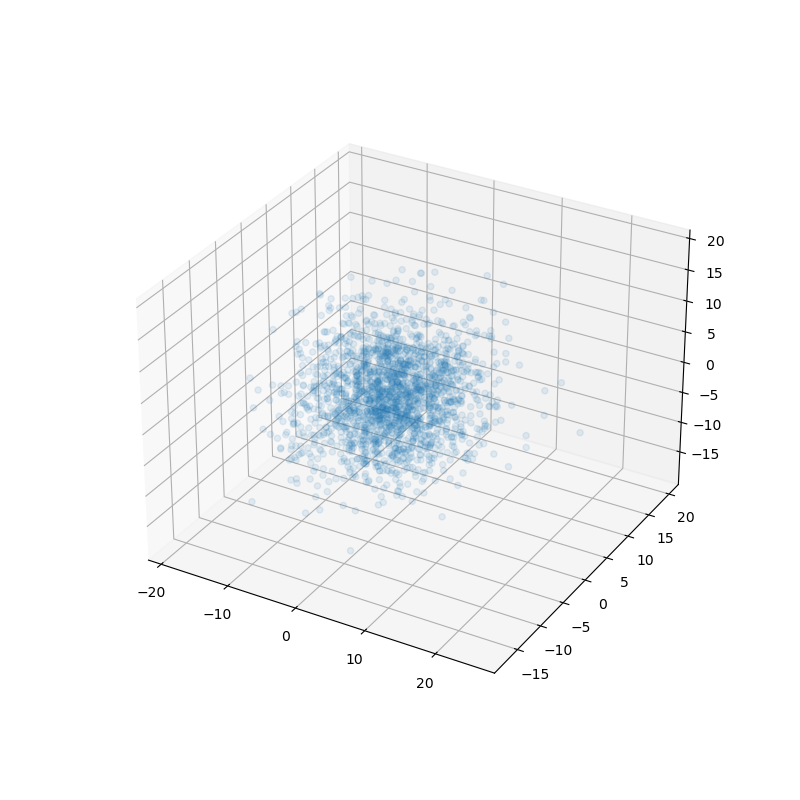

In [32]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*nextnoisyprojections, alpha=0.1)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
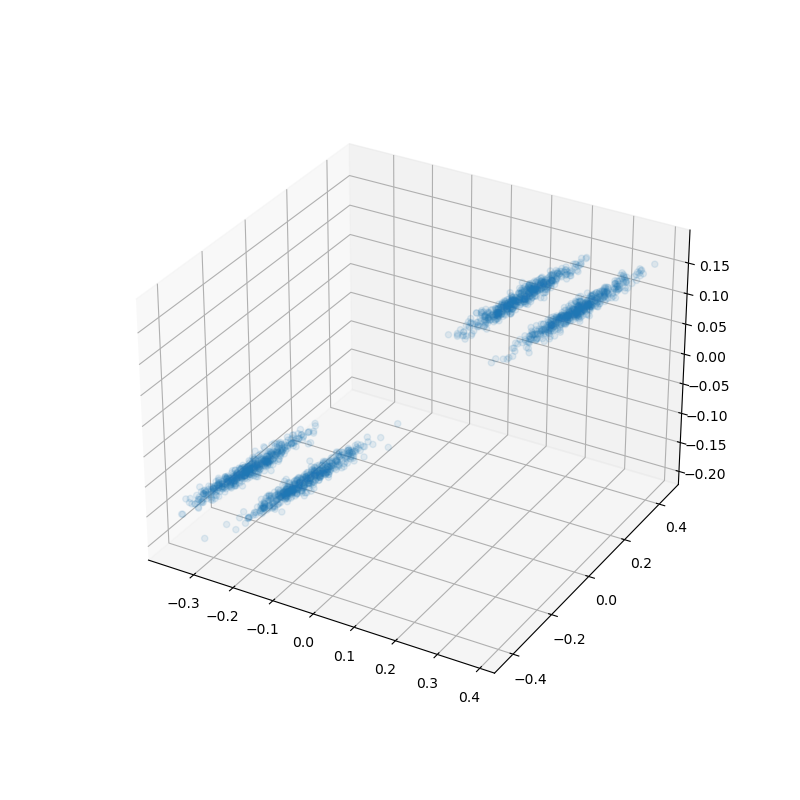

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*nextcleanprojections, alpha=0.1)
plt.show()

Notice that even in the next pair of dimensions, there is no visible trace of the signal in noise. The original dataset is on effectively 2-D, which is reflected even in the next few dimensions.

## Principal components:
Let us go back to the singular values and plot them:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
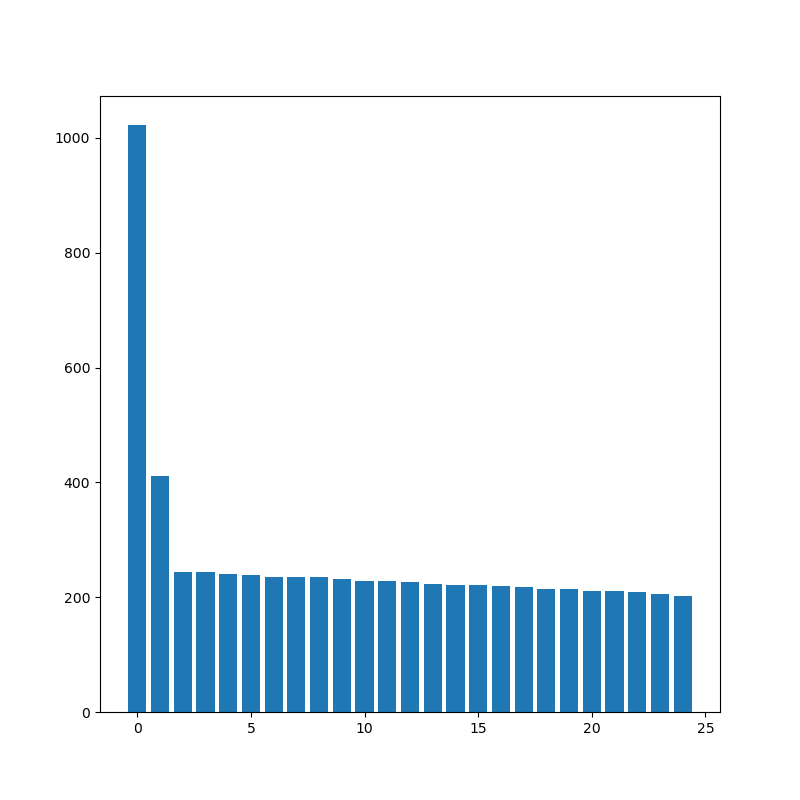

In [34]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.bar(np.arange(S.shape[0]), S)
plt.show()

The singular value corresponding to the first principal component is larger than the rest, which are similar.

The second principal component is also bigger than the rest, but by not as much. 

Does it make sense? we started with 2D data, shouldn't we expect the first two singular values to significantly larger then the rest?

Contributors: 
- Neelesh Ramachandran
- Kareem Ahmad
- Kumar Krishna Agrawal
